In [7]:
import os 
import numpy as np
import local_utils
import hausdorff_from_dir 
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
datadir = Path('../work/heterog_1000/MC_expt_2020-02-01-18-15/export_1000')
section_names = ['0_500','501_1000']
varnames = ['AEM','conc']

In [53]:
def names2latex(names):
    new_names = []
    for n in names:
        n=n.replace('inland','')
        n = n.replace('_.','$_{')
        n = n.replace('.','}$')
        
        if n.find('$')==-1:
            n = n.replace('}','}$')
            n = n.replace('_{','$_{')

        if n.startswith('wel'):
            n = 'wel$_{' + n[-1] + '}$'
#         n = '$' + n + '$'
#         if n.find('_')==-1:
#             n = n + '\n '
        new_names.append(n)
    return new_names



In [10]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
#     ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_xticklabels('',minor=False)
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right',minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')
    out = plt.gca()
    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.set_ylim(0,2)
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(0, 2, 5)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Norm. sensitivity',rotation=90)
    return out

def corrplot(data, marker='s',
             palette=sns.diverging_palette(20, 220, n=256),**kwargs):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    out= heatmap(
        corr['x'], corr['y'],
        color=corr['value'],
#         palette=sns.diverging_palette(20, 220, n=256),
        palette=palette,
        size=corr['value'].abs(),
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        **kwargs
    )
    return out


In [11]:
def load_reset_df(fname):
    df = pd.read_csv(datadir.joinpath(fname))
    df.rename(columns={'Unnamed: 0':'index'} ,inplace=True)
    df.set_index('index',inplace=True)
    return df
    
def drop_rows_cols(df,names):
    return df.drop(columns=names).drop(index=names)

def rename_df(df):
    rename_dict_col = {}
    [rename_dict_col.__setitem__(n, n_new) for n,n_new in zip(df.columns,names2latex(df.columns))];
    rename_dict_ind = {}
    [rename_dict_ind.__setitem__(n, n_new)  for n,n_new in zip(df.columns,names2latex(df.columns)) if (not n.startswith('Unnamed'))];
    return df.rename(columns=rename_dict_col,index=rename_dict_ind)

def top_rows_cols(df,n_top=5):
    ind_sort = pd.concat((df.max(axis=1),df.max(axis=0)),axis=1).max(axis=1).sort_values(ascending=False).index
    top_rows = df.max(axis=1).sort_values(ascending=False)[:n_top].index.values
    top_cols =  df.max(axis=0).sort_values(ascending=False)[:n_top].index.values
    top_union = list(set(top_rows) | set(top_cols)) 
    namlist = []
    for v in df.loc[top_union,top_union].max(axis=1).values:
        row = df[(df==v).values]
        colname = (row.max())[row.max()==v].index.values[0]
        rowname = row.index.values[0]
        namlist.append(colname)
        namlist.append(rowname)
    #     print(colname,rowname)
    for v in df.loc[top_union,top_union].max(axis=0).values:
        row = df[(df==v).values]
        colname = (row.max())[row.max()==v].index.values[0]
        rowname = row.index.values[0]
        namlist.append(colname)
        namlist.append(rowname)
    #     print(colname,rowname)
    namlist = np.unique(np.asarray(namlist))

    df_plot = df.loc[namlist,namlist]
    top_rows = df_plot.max(axis=1).sort_values(ascending=False).index.values
    top_cols = df_plot.max(axis=0).sort_values(ascending=False).index.values
    top_union = list(set(top_rows) | set(top_cols))
    top_union_sorted = pd.concat((df_plot.max(axis=1),
                                  df_plot.max(axis=0)),axis=1).max(axis=1).sort_values(ascending=False).index.values
    return df_plot.loc[top_union_sorted,top_union_sorted]


def corrplot_df(df_plot,ax=None,title=None,**kwargs):
    if ax is None:
        f,ax=plt.subplots(1,figsize=(3,3))
#     palette = sns.light_palette((210, 90, 60), input="husl",n_colors=4)
    plt.sca(ax)
    palette = sns.cubehelix_palette(n_colors=4, start=.5, rot=-.75)

    out  = corrplot(df_plot,marker='o',palette=palette,color_range=(.25,1.75),**kwargs)
    ax.set_aspect(1)
    if title is None:
        if len(cluster)>0:
            plt.suptitle('{}, Cluster {}'.format(varname_plot,cluster[1:]))
        else:
            plt.suptitle('{}, Average of clusters'.format(varname_plot,))
    else:
        plt.suptitle(title)
    return out

In [6]:
import matplotlib
from set_rc import *
set_rc(11,11,12)

iplot=0
# f,axs = plt.subplots(2,2,figsize=(10,10))
for varname in varnames:
    if varname=='conc':
        varname_plot = 'Concentration'
    else:
        varname_plot = 'AEM data'
        
    for section_name in section_names:
        if section_name=='0_500':
            section_name_plot = 'Unconfined'
        else:
            section_name_plot = 'Confined'
        
#         plt.sca()
#         ax = plt.gca()
        iplot= iplot+1
        vals = np.zeros((8,27,27),dtype=float)
        for cluster_val in range(1,9):
            cluster = '_{}'.format(cluster_val)

            #Load and re-format names
            fname = 'matrixDGSA_{}_{}{}.csv'.format(varname,section_name,cluster)
            D = np.loadtxt(datadir.joinpath('D_{}_{}.csv'.format(varname,section_name)),delimiter=',')

            df = pd.read_csv(datadir.joinpath(fname))
            df.rename(columns={'Unnamed: 0':'index'} ,inplace=True)
            df.set_index('index',inplace=True)
            vals[cluster_val-1]=df.values
        
        for i,row in enumerate(df.index):
            df.loc[row,:] = vals.mean(axis=0)[i,:]            
        df = rename_df(df)
        df_plot = top_rows_cols(df,n_top=5)
        cluster = ''
        f,ax=plt.subplots(1,figsize=(3,3))
        out = corrplot_df(df_plot,ax=ax,
                          size_range=(0,3),
                          size_scale=400,
                          title='{}, {}'.format(varname_plot,section_name_plot))
        plt.savefig(datadir.joinpath('Sens_{}_{}_5.png'
                                     .format(varname,section_name)),dpi=500,bbox_inches='tight')
        plt.show()

KeyboardInterrupt: 

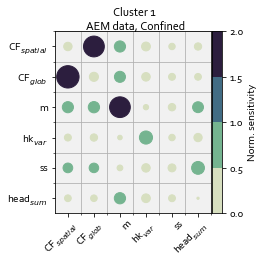

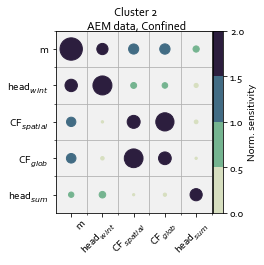

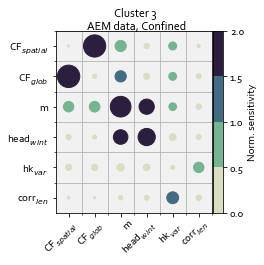

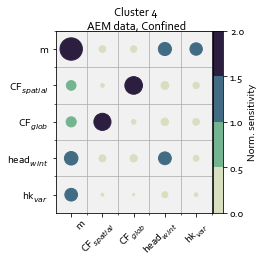

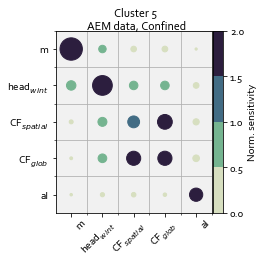

In [168]:
# cluster = '_1'
# section_name = '0_500'
section_name = '501_1000'

# varname = 'conc'
varname = 'AEM'

n_cluster=5

for cluster_val in range(1,n_cluster+1):
    if cluster_val==n_cluster+1:
        cluster=''
    else:
        cluster = '_{}'.format(cluster_val)
    
    if varname=='conc':
        varname_plot = 'Concentration'
    else:
        varname_plot = 'AEM data'
    if section_name=='0_500':
        section_name_plot = 'Unconfined'
    else:
        section_name_plot = 'Confined'

    #Load and re-format names
    fname = 'matrixDGSA_{}_{}{}.csv'.format(varname,section_name,cluster)
    D = np.loadtxt(datadir.joinpath('D_{}_{}.csv'.format(varname,section_name)),delimiter=',')

    df = load_reset_df(fname)
    df = drop_rows_cols(df, names = ['clay_.lyryn.',])
    if section_name=='501_1000':
        df = drop_rows_cols(df, names = ['rech', 'rech_.farm.', 'riv_.stg.', 'riv_.cond.'])
    if varname=='conc':
        df = drop_rows_cols(df, names = ['m',])
    df = rename_df(df)

    df_plot = top_rows_cols(df,n_top=5)

    f,ax=plt.subplots(1,figsize=(3,3.35))
    corrplot_df(df_plot,ax=ax,title='Cluster {} \n{}, {}'.format(cluster_val,varname_plot,section_name_plot))
    plt.savefig(datadir.joinpath('Sens_{}_{}{}_5.png'
                             .format(varname,section_name,cluster)),dpi=500,bbox_inches='tight')
    plt.show()

In [59]:
import matplotlib
from set_rc import *
set_rc(11,11,12)
section_name = '501_1000'

# varname = 'conc'
varname = 'AEM'

if varname=='conc':
    varname_plot = 'Concentration'
else:
    varname_plot = 'AEM data'
if section_name=='0_500':
    section_name_plot = 'Unconfined'
else:
    section_name_plot = 'Confined'

inputs = pd.read_csv(datadir.joinpath('ParametersValues_{}_{}.csv'.
                                     format(varname,section_name)),delimiter=',')
clusters = np.loadtxt(datadir.joinpath('Cluster_{}_{}.csv'.
                                     format(varname,section_name)),delimiter=',')
inputs = inputs.assign(cluster= clusters)

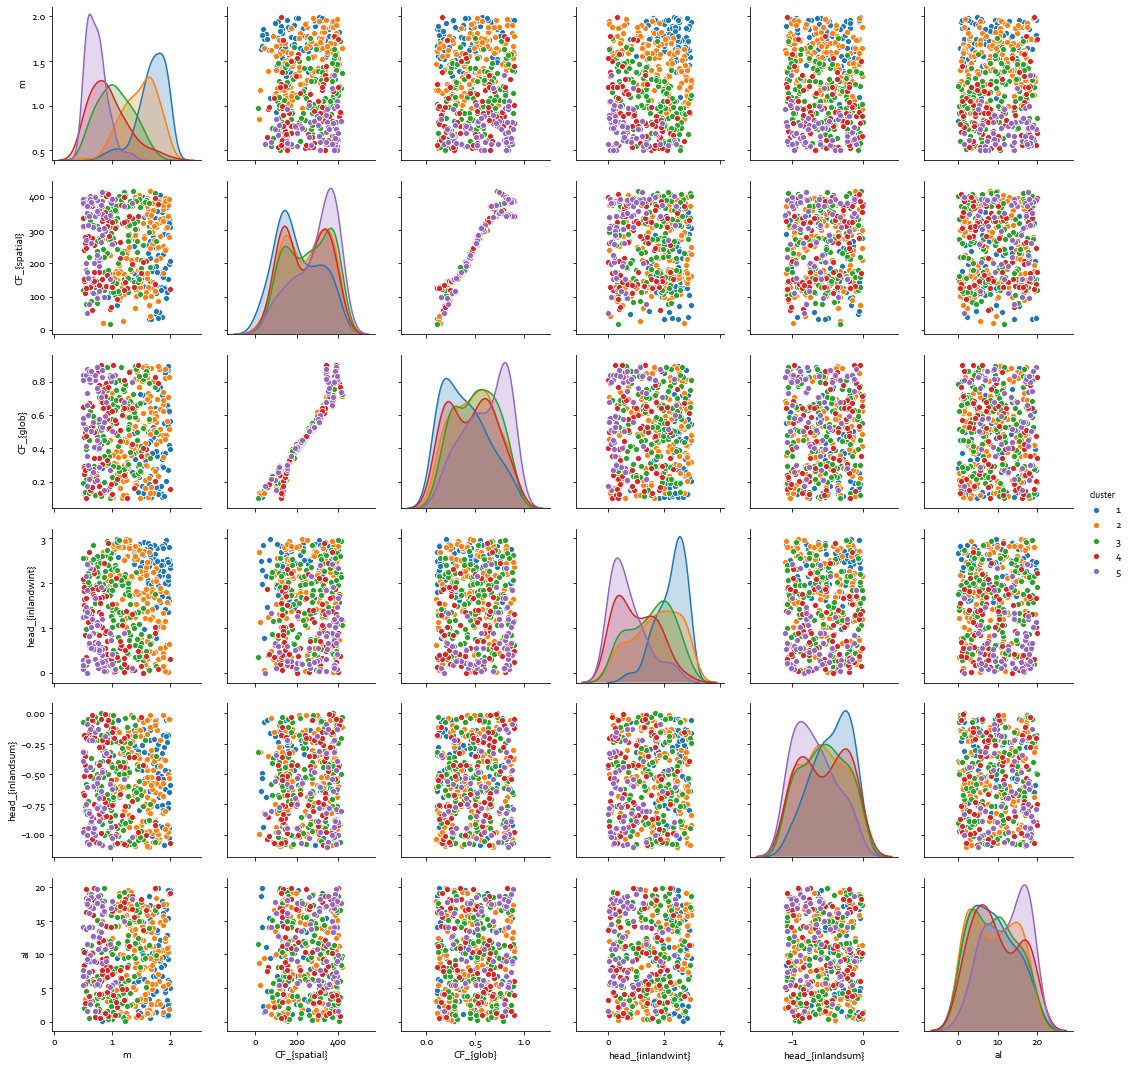

In [31]:
df_plot = inputs

g = sns.pairplot(df_plot,vars=test_vars,hue='cluster',hue_order=range(1,6),)

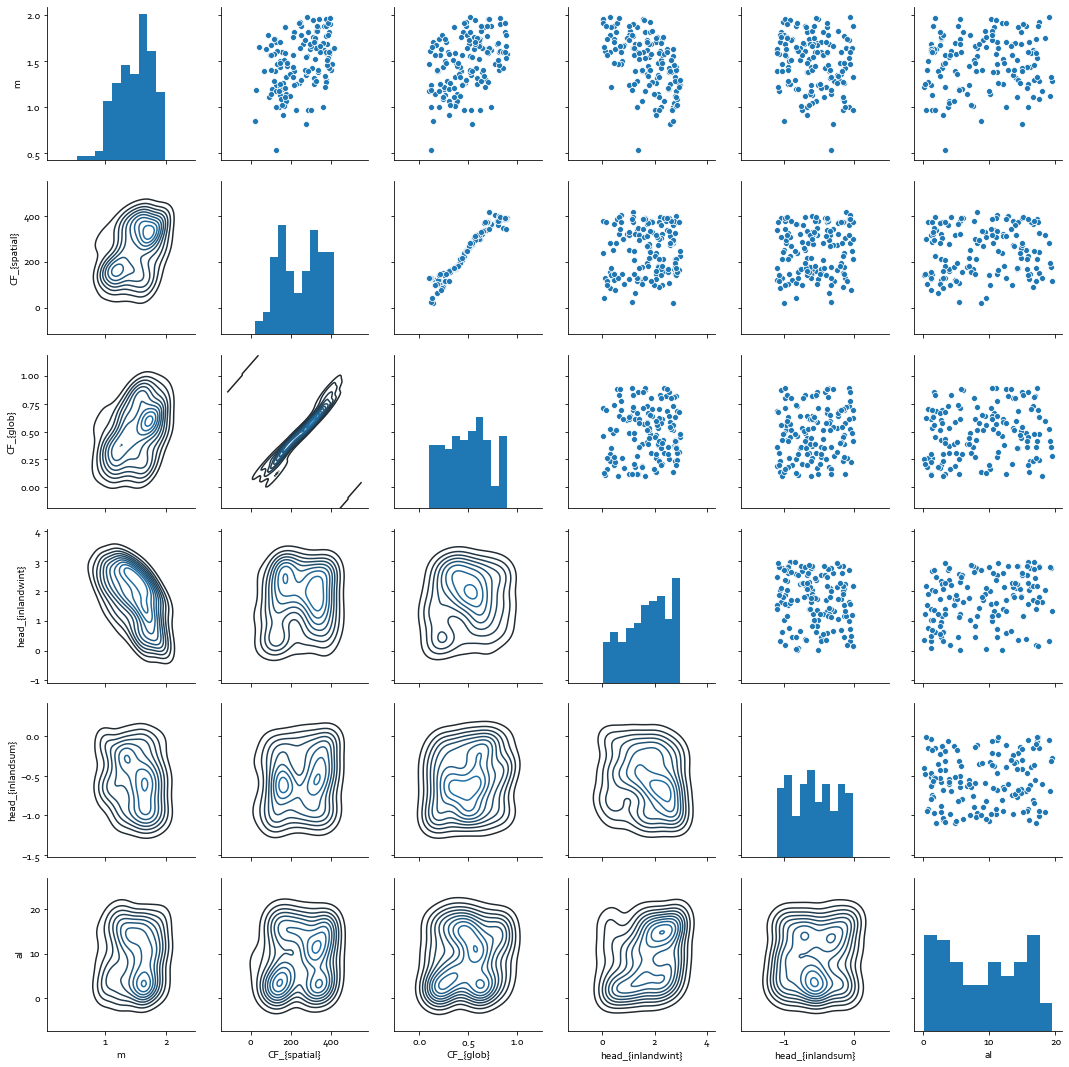

In [28]:
test_vars = ['m','CF_{spatial}','CF_{glob}','head_{inlandwint}','head_{inlandsum}','al']
df_plot = inputs.loc[inputs.cluster==2,:]
g = sns.PairGrid(df_plot,vars=test_vars)#hue='cluster',hue_order=range(1,6),)
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, lw=2)#sns.pairplot(df_plot,vars=test_vars,kind='reg')#hue='cluster',hue_order=range(1,6),

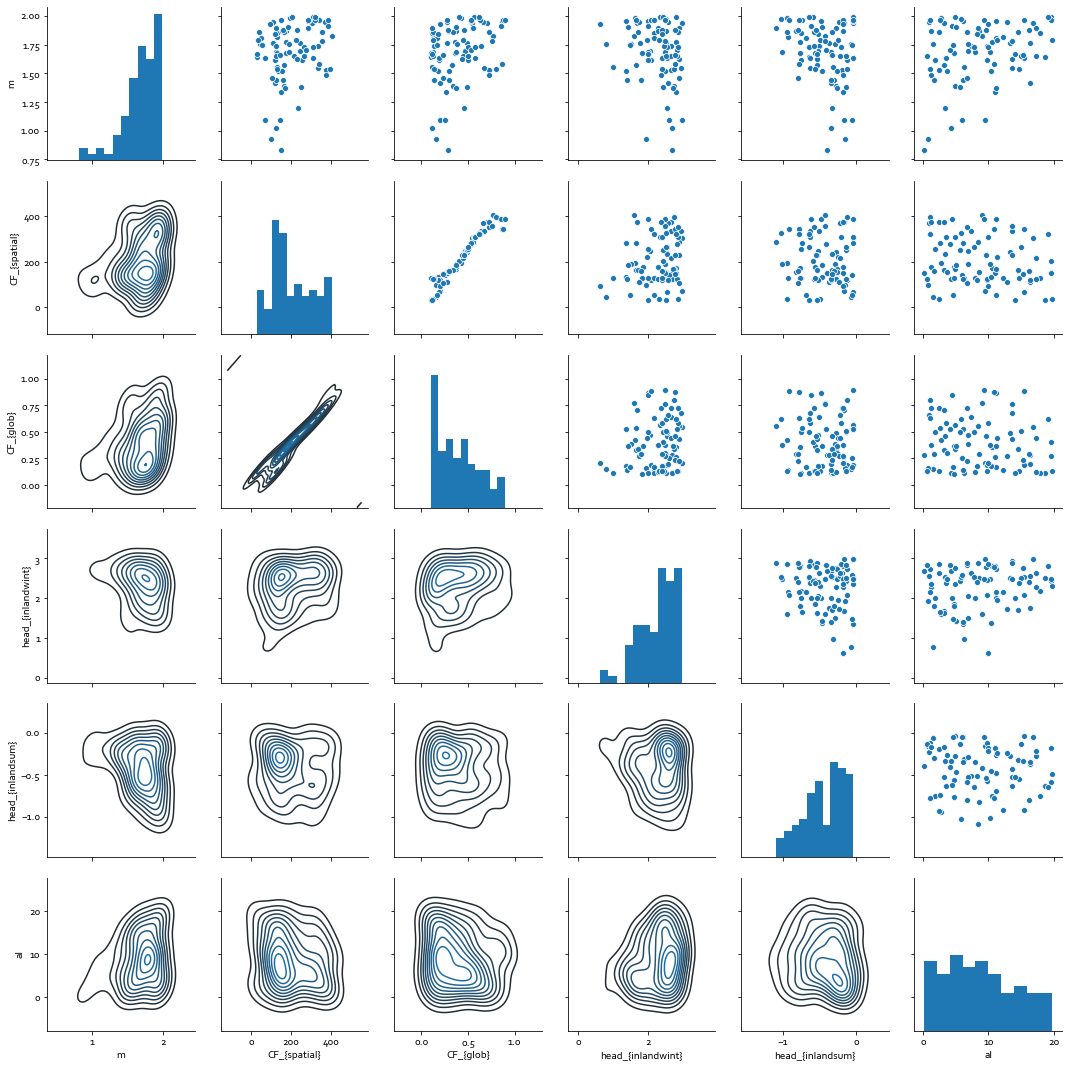

In [29]:
test_vars = ['m','CF_{spatial}','CF_{glob}','head_{inlandwint}','head_{inlandsum}','al']
df_plot = inputs.loc[inputs.cluster==1,:]
g = sns.PairGrid(df_plot,vars=test_vars)#hue='cluster',hue_order=range(1,6),)
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, lw=2)#sns.pairplot(df_plot,vars=test_vars,kind='reg')#hue='cluster',hue_order=range(1,6),

In [124]:
# section_name = '0_500'
section_name = '501_1000'

# varname = 'conc'
varname = 'AEM'
if varname=='conc':
    varname_plot = 'Concentration'
else:
    varname_plot = 'AEM data'
if section_name=='0_500':
    section_name_plot = 'Unconfined'
else:
    section_name_plot = 'Confined'


inputs = pd.read_csv(datadir.joinpath('ParametersValues_{}_{}.csv'.
                                     format(varname,section_name)),delimiter=',')
clusters = np.loadtxt(datadir.joinpath('Cluster_{}_{}.csv'.
                                     format(varname,section_name)),delimiter=',')
inputs = inputs.assign(cluster= clusters)
df_plot = rename_df(inputs)

KeyError: 'head_{inlandwint}'

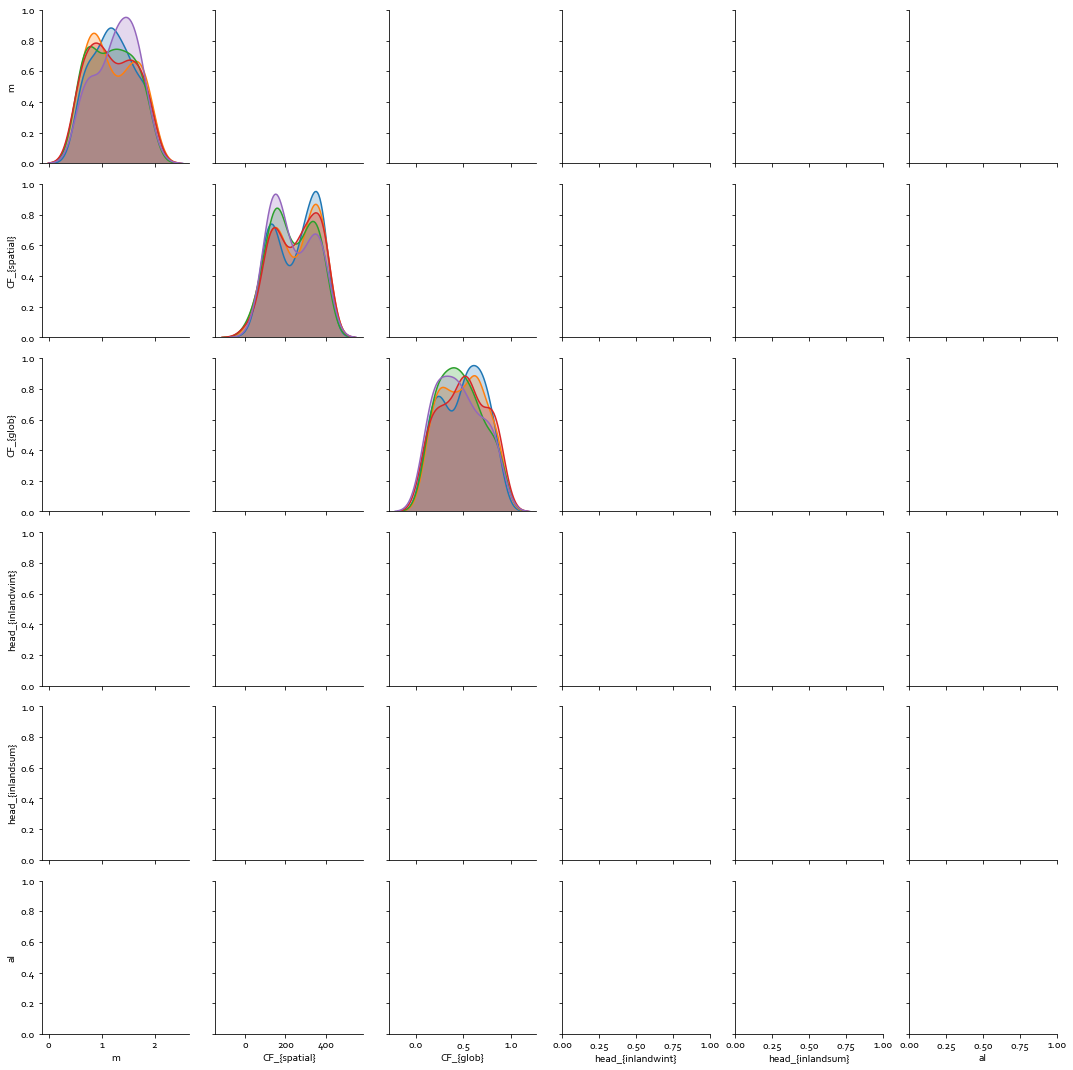

In [47]:
test_vars = ['m','CF$_{spatial}$','CF$_{glob}$','head$_{inlandwint}$','head$_{inlandsum}$','al']


g = sns.pairplot(df_plot,vars=test_vars,hue='cluster',hue_order=range(1,6),)

In [95]:
fake_parula = np.array([
    [0.2081,    0.1663,    0.5292],
    [0.0783,    0.5084,    0.8364],
    [0.1869,    0.7190,    0.6379],
    [0.8214,    0.7327,    0.3486],
    [0.9763,    0.9831,    0.0538],
])

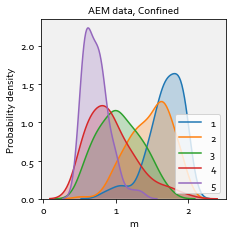

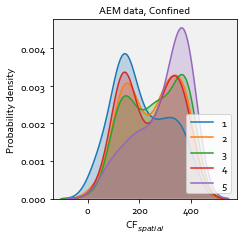

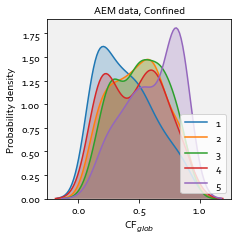

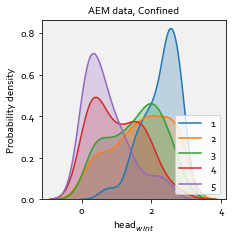

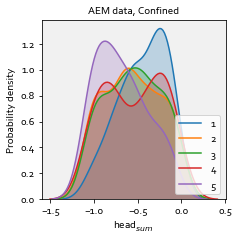

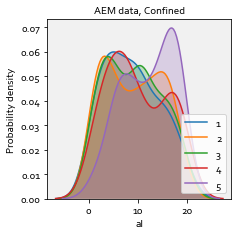

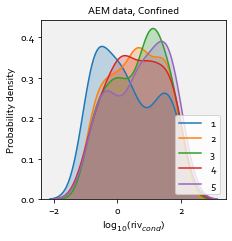

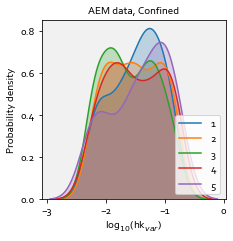

In [152]:
test_vars = ['m','CF$_{spatial}$','CF$_{glob}$','head$_{wint}$','head$_{sum}$','al','riv$_{cond}$','hk$_{var}$']
for v in test_vars: 
    g=[]
    f,ax = plt.subplots(1,figsize=(3.3,3.3))
#     for c in sorted(inputs.cluster.unique()):
    for c in (1,2,3,4,5):
        if v.startswith('hk') or v.startswith('riv'):
            g.append(sns.kdeplot(np.log10(df_plot.loc[df_plot.cluster==c,v]),shade=True,label=int(c),legend=False))
            xlbl = 'log$_{10}$(' + v + ')'
        else:
            xlbl = v
            g.append(sns.kdeplot(df_plot.loc[df_plot.cluster==c,v],shade=True,label=int(c),legend=False))
    ax.set_facecolor('#F1F1F1')
    plt.legend(loc='lower right')
    plt.xlabel(xlbl)
    plt.ylabel('Probability density')
    plt.title('{}, {}'.format(varname_plot,section_name_plot))
#     plt.savefig(datadir.joinpath('ParamDist_{}_{}_{}_5.png'
#                              .format(varname,section_name,v)),dpi=500,bbox_inches='tight')
#Grab the colors
dists = [c for c in g[0].get_children() if type(c)==matplotlib.lines.Line2D]
colors = [c.get_color() for c in dists]
colors_rgb = [tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for h in colors]

array([0.12156863, 0.46666667, 0.70588235])

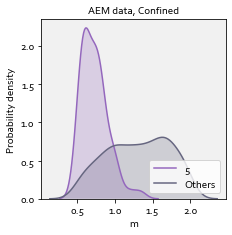

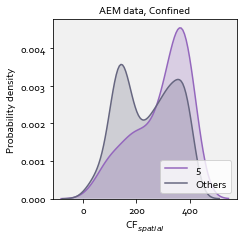

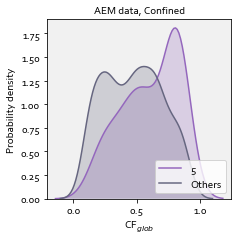

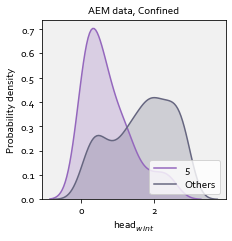

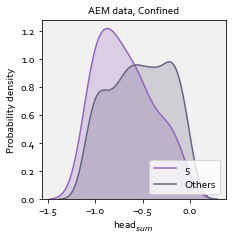

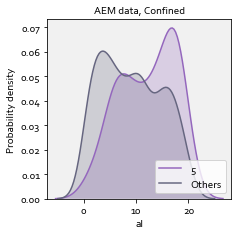

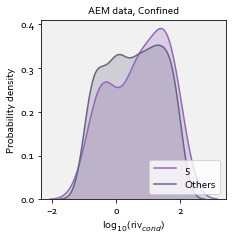

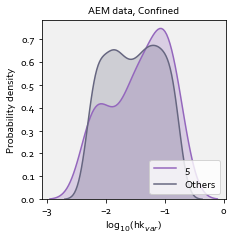

In [164]:
test_cluster=5
other_clusters = np.arange(1,6)
other_clusters = np.delete(other_clusters,np.argwhere(other_clusters==test_cluster))
test_vars = ['m','CF$_{spatial}$','CF$_{glob}$','head$_{wint}$','head$_{sum}$','al','riv$_{cond}$','hk$_{var}$']

for v in test_vars: 
    g=[]
    f,ax = plt.subplots(1,figsize=(3.3,3.3))
#     for c in sorted(inputs.cluster.unique()):
    for c in (test_cluster,):
        cluster_color = np.asarray(colors_rgb[c-1])/255
        other_color = [.4,.4,.5]
        if v.startswith('hk') or v.startswith('riv'):
            g.append(sns.kdeplot(np.log10(df_plot.loc[df_plot.cluster==c,v]),shade=True,label=int(c),color=cluster_color,legend=False))
            g.append(sns.kdeplot(np.log10(df_plot.loc[df_plot.cluster.isin((1,2,3,4)),v]),shade=True,color=other_color,label='Others',legend=False))

            xlbl = 'log$_{10}$(' + v + ')'
        else:
            xlbl = v
            g.append(sns.kdeplot(df_plot.loc[df_plot.cluster==c,v],shade=True,label=int(c),color=cluster_color,legend=False))
            g.append(sns.kdeplot(df_plot.loc[df_plot.cluster.isin((1,2,3,4)),v],shade=True,color=other_color,label='Others',legend=False))
    ax.set_facecolor('#F1F1F1')
    plt.legend(loc='lower right')
    plt.xlabel(xlbl)
    plt.ylabel('Probability density')
    plt.title('{}, {}'.format(varname_plot,section_name_plot))
#     plt.savefig(datadir.joinpath('ParamDist_{}_{}_{}_{}vAll.png'
#                          .format(varname,section_name,v,test_cluster)),dpi=500,bbox_inches='tight')


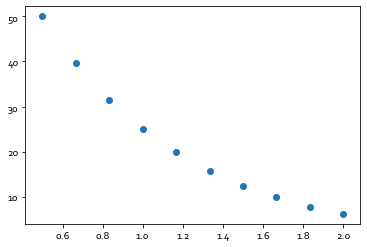

In [130]:
plt.scatter(np.linspace(.5,2,10),10*0.25**np.linspace(.5,2,10)*10)